In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# my solutions
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.manifold import TSNE
# from hmmlearn import hmm

Данное задание относится к задаче класетризации, так как на тренировочных данных нет заранее известноко правильного id.

Так как это задача класстеризации, то можно попробовать решить задачу различными методами, например, kmeans, dbscan случаный лес, градиентный бустинг или нейросетью(lstm, transformers).
Для оценки результата можно будет восползоваться accurancy, precission, recall, f1.

### Global variables

In [2]:
path = './data/'
random_state = 40
n_init = 10

In [3]:
train = pd.read_csv(path + 'train.csv', index_col=0)

In [4]:
train

,user_id,ts,gate_id
0,18,2022-07-29 09:08:54,7
1,18,2022-07-29 09:09:54,9
3,18,2022-07-29 09:10:06,5
4,18,2022-07-29 09:10:08,5
5,18,2022-07-29 09:10:34,10
...,...,...,...
37512,6,2022-12-31 17:21:19,10
37513,6,2022-12-31 20:38:56,11
37514,6,2022-12-31 20:39:22,6
37515,6,2022-12-31 20:39:23,6


In [4]:
test = pd.read_csv(path + 'test.csv', index_col=0)

In [6]:
test

,ts,gate_id,lost_id
37518,2023-01-03 08:21:00,9,1
37520,2023-01-03 08:21:18,5,1
37521,2023-01-03 08:21:19,5,1
37522,2023-01-03 08:21:39,10,1
37523,2023-01-03 08:32:49,15,19
...,...,...,...
44637,2023-02-24 17:08:57,10,15
44638,2023-02-24 19:43:36,11,15
44639,2023-02-24 19:44:00,4,15
44640,2023-02-24 19:44:01,4,15


In [5]:
all_data = pd.concat([train, test], axis=0)

In [8]:
all_data

,user_id,ts,gate_id,lost_id
0,18.0,2022-07-29 09:08:54,7,NaN
1,18.0,2022-07-29 09:09:54,9,NaN
3,18.0,2022-07-29 09:10:06,5,NaN
4,18.0,2022-07-29 09:10:08,5,NaN
5,18.0,2022-07-29 09:10:34,10,NaN
...,...,...,...,...
44637,NaN,2023-02-24 17:08:57,10,15.0
44638,NaN,2023-02-24 19:43:36,11,15.0
44639,NaN,2023-02-24 19:44:00,4,15.0
44640,NaN,2023-02-24 19:44:01,4,15.0


In [6]:
# Доля тест во всей выборке

sum(all_data['lost_id'].notnull()) / all_data['lost_id'].shape[0] 

0.15840352220520673

In [7]:
all_data['ts'] = pd.to_datetime(all_data['ts'])

In [8]:
test['ts'] = pd.to_datetime(test['ts'])

In [9]:
train['ts'] = pd.to_datetime(train['ts'])

<Axes: >

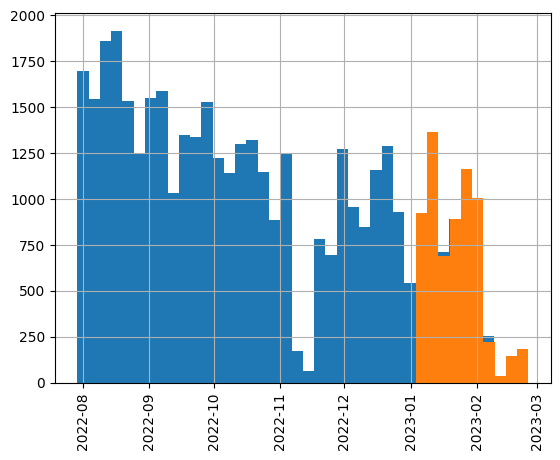

In [10]:
plt.figure()
plt.xticks(rotation='vertical')
all_data['ts'].hist(bins=40)
test['ts'].hist(bins=10)

In [14]:
all_data['lost_id'].value_counts().count()

np.int64(34)

# Here we continue

In [15]:
train_gate_list = sorted(list(train['gate_id'].unique()))

In [16]:
test_gate_list = sorted(list(test['gate_id'].unique()))

In [17]:
only_test = [gate for gate in test_gate_list if gate not in train_gate_list]

In [18]:
only_test

[np.int64(2)]

In [19]:
test[test['gate_id']==2]

,ts,gate_id,lost_id
39911,2023-01-13 16:49:52,2,33
39912,2023-01-13 16:49:54,2,33
39928,2023-01-13 18:21:16,2,33
39929,2023-01-13 18:21:19,2,33


In [20]:
all_gates = sorted(list(all_data['gate_id'].unique()))
all_gates

[np.int64(-1),
 np.int64(0),
 np.int64(1),
 np.int64(2),
 np.int64(3),
 np.int64(4),
 np.int64(5),
 np.int64(6),
 np.int64(7),
 np.int64(8),
 np.int64(9),
 np.int64(10),
 np.int64(11),
 np.int64(12),
 np.int64(13),
 np.int64(14),
 np.int64(15),
 np.int64(16)]

In [21]:
# Составим список турникетов вида "gate_номер"

list_gate_vars = ['gate_'+str(i) for i in all_gates]

In [22]:
# Теперь: cделаем бинарные переменные

new_vals = pd.get_dummies(all_data['gate_id']).values 

In [23]:
# Припишем новые бинарные переменные "турникет" к полной выборке

all_data[list_gate_vars] = new_vals

In [24]:
# Список дней недели

list_dow = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

In [25]:
# Припишем новые бинарные переменные "день недели" к полной выборке

all_data[list_dow] = pd.get_dummies(all_data['ts'].dt.day_name())[list_dow].values

In [26]:
all_data['ts'].dt.day_name().value_counts()

ts
Friday       8894
Thursday     8371
Wednesday    8066
Monday       7809
Tuesday      7642
Saturday      687
Sunday        323
Name: count, dtype: int64

In [27]:
all_data

,user_id,ts,gate_id,lost_id,gate_-1,gate_0,gate_1,gate_2,gate_3,gate_4,...,gate_14,gate_15,gate_16,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,18.0,2022-07-29 09:08:54,7,NaN,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,18.0,2022-07-29 09:09:54,9,NaN,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,18.0,2022-07-29 09:10:06,5,NaN,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,18.0,2022-07-29 09:10:08,5,NaN,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
5,18.0,2022-07-29 09:10:34,10,NaN,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44637,NaN,2023-02-24 17:08:57,10,15.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
44638,NaN,2023-02-24 19:43:36,11,15.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
44639,NaN,2023-02-24 19:44:00,4,15.0,False,False,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False
44640,NaN,2023-02-24 19:44:01,4,15.0,False,False,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False


In [28]:
all_data['hour'] = all_data['ts'].dt.hour.values

In [29]:
# Список переменных вида "hour_час в полной выборке"

list_hours = ['hour_'+str(i) for i in sorted(list(all_data['ts'].dt.hour.unique()))] 

In [30]:
# Добавим бинарные переменные для месяца

all_data[list_hours] = pd.get_dummies(all_data['ts'].dt.hour.values).values

In [31]:
all_data['min'] = all_data['ts'].dt.minute.values

In [32]:
all_data['day'] = all_data['ts'].dt.day.values

In [33]:
all_data['month'] = all_data['ts'].dt.month.values

In [34]:
all_data['dayofweek'] = all_data['ts'].dt.dayofweek.values

In [35]:
all_data.columns

Index(['user_id', 'ts', 'gate_id', 'lost_id', 'gate_-1', 'gate_0', 'gate_1',
       'gate_2', 'gate_3', 'gate_4', 'gate_5', 'gate_6', 'gate_7', 'gate_8',
       'gate_9', 'gate_10', 'gate_11', 'gate_12', 'gate_13', 'gate_14',
       'gate_15', 'gate_16', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday', 'Saturday', 'Sunday', 'hour', 'hour_0', 'hour_1', 'hour_3',
       'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'min', 'day',
       'month', 'dayofweek'],
      dtype='object')

In [36]:
train['ts'].agg(['min', 'max','count'])

min      2022-07-29 09:08:54
max      2022-12-31 20:39:31
count                  35172
Name: ts, dtype: object

In [37]:
test['ts'].agg(['min','max','count'])

min      2023-01-03 08:21:00
max      2023-02-24 19:44:09
count                   6620
Name: ts, dtype: object

# Val index

In [38]:
val_index = train['ts'] > '2022-11-30'

In [39]:
sum(val_index) / val_index.shape[0]

0.18614238598885477

In [40]:
all_data.head(2)

,user_id,ts,gate_id,lost_id,gate_-1,gate_0,gate_1,gate_2,gate_3,gate_4,...,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,min,day,month,dayofweek
0,18.0,2022-07-29 09:08:54,7,NaN,False,False,False,False,False,False,...,False,False,False,False,False,False,8,29,7,4
1,18.0,2022-07-29 09:09:54,9,NaN,False,False,False,False,False,False,...,False,False,False,False,False,False,9,29,7,4


In [41]:
train_idx = all_data['lost_id'].isnull()
train = all_data.loc[train_idx]
test = all_data.loc[~train_idx]

In [42]:
display(train.tail(1), test.head(1))

,user_id,ts,gate_id,lost_id,gate_-1,gate_0,gate_1,gate_2,gate_3,gate_4,...,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,min,day,month,dayofweek
37516,6.0,2022-12-31 20:39:31,9,NaN,False,False,False,False,False,False,...,False,False,True,False,False,False,39,31,12,5


,user_id,ts,gate_id,lost_id,gate_-1,gate_0,gate_1,gate_2,gate_3,gate_4,...,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,min,day,month,dayofweek
37518,NaN,2023-01-03 08:21:00,9,1.0,False,False,False,False,False,False,...,False,False,False,False,False,False,21,3,1,1


In [43]:
X = train[~val_index].copy()
X_val = train[val_index].copy()

y = X['user_id'].astype(int)
y_val = X_val['user_id'].astype(int)

In [45]:
cols_cat = list(all_data.columns[4:])

In [46]:
X = X[cols_cat].astype(int)
X_val = X_val[cols_cat].astype(int)

In [47]:
X

,gate_-1,gate_0,gate_1,gate_2,gate_3,gate_4,gate_5,gate_6,gate_7,gate_8,...,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,min,day,month,dayofweek
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,8,29,7,4
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,9,29,7,4
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,10,29,7,4
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,10,29,7,4
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,10,29,7,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30529,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,45,29,11,1
30530,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,46,29,11,1
30531,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,50,29,11,1
30532,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,50,29,11,1


In [48]:
# Сделаем нормирование отдельными скейлерами по X и по X_val, т.к. будущие данные скорее всего изменятся

scaler_X = StandardScaler()
scaler_X_val = StandardScaler()

scaler_X.fit(X)
scaler_X_val.fit(X_val)

X_scaled = scaler_X.transform(X)
X_val_scaled = scaler_X_val.transform(X_val)

In [49]:
print('Признаки, всего', len(X.columns))
print(list(X.columns))

Признаки, всего 51
['gate_-1', 'gate_0', 'gate_1', 'gate_2', 'gate_3', 'gate_4', 'gate_5', 'gate_6', 'gate_7', 'gate_8', 'gate_9', 'gate_10', 'gate_11', 'gate_12', 'gate_13', 'gate_14', 'gate_15', 'gate_16', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'hour', 'hour_0', 'hour_1', 'hour_3', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'min', 'day', 'month', 'dayofweek']


### Modeling

#### BaseLine: LogisticRegression

In [50]:
clf = LogisticRegression(random_state=1,solver='saga').fit(X_scaled, y)

y_pred = clf.predict(X_scaled)

y_val_pred = clf.predict(X_val_scaled)

/home/dev/Projects/Programming/ML/task_shift/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [51]:
results = pd.DataFrame(y_val)
results['pred'] = y_val_pred
results

,user_id,pred
30535,1,3
30536,1,18
30538,1,18
30539,1,18
30540,1,18
...,...,...
37512,6,37
37513,6,29
37514,6,33
37515,6,33


In [52]:
results['user_id'].unique().shape

(43,)

In [53]:
test_orig = pd.read_csv(path + 'test.csv', index_col=0)
test_orig

,ts,gate_id,lost_id
37518,2023-01-03 08:21:00,9,1
37520,2023-01-03 08:21:18,5,1
37521,2023-01-03 08:21:19,5,1
37522,2023-01-03 08:21:39,10,1
37523,2023-01-03 08:32:49,15,19
...,...,...,...
44637,2023-02-24 17:08:57,10,15
44638,2023-02-24 19:43:36,11,15
44639,2023-02-24 19:44:00,4,15
44640,2023-02-24 19:44:01,4,15


In [54]:
# Предскажем самым частотным user_id на val

def mode_1(x):
    return x.mode().iloc[0]

res = results.groupby('user_id')['pred'].agg([mode_1, 'count']) 
display(res)

res = res.reset_index(); del res['count']

,mode_1,count
user_id,,
0,55,286
1,1,325
2,55,39
3,3,179
5,31,6
6,37,272
9,12,142
10,11,17
11,37,239


In [55]:
print('correct', (res['user_id'] == res['mode_1']).sum())
print('out of', res.shape[0])
print('or', int((res['user_id'] == res['mode_1']).sum()*100 / res.shape[0]), '%')

correct 5
out of 43
or 11 %


In [56]:
# Train предсказуемо имеет более высокую метрику

results2 = pd.DataFrame(y)
results2['pred'] = y_pred
res2 = results2.groupby('user_id')['pred'].agg([mode_1]).reset_index()

print('correct', (res2['user_id'] == res2['mode_1']).sum())
print('out of', res2.shape[0])
print('or', int((res2['user_id'] == res2['mode_1']).sum()*100 / res2.shape[0]), '%')

correct 13
out of 50
or 26 %


In [66]:
# На реальном тесте в задаче можно ожидать около 10% правильных ответом таким наивным подходом 
# (но из-за весов значение метрики будет другим) 

In [57]:
test['lost_id']

37518     1.0
37520     1.0
37521     1.0
37522     1.0
37523    19.0
         ... 
44637    15.0
44638    15.0
44639    15.0
44640    15.0
44641    15.0
Name: lost_id, Length: 6620, dtype: float64

In [58]:
X = train.copy()
y = X['user_id'].astype(int)
X_test = test.copy()

In [59]:
X = X[cols_cat].astype(int)
X_test = X_test[cols_cat].astype(int)

In [60]:
# Сделаем нормирование отдельными скейлерами по X и по X_test, т.к. будущие данные скорее всего изменятся

scaler_X = StandardScaler()
scaler_X_test = StandardScaler()

scaler_X.fit(X)
scaler_X_test.fit(X_test)

X_scaled = scaler_X.transform(X)
X_test_scaled = scaler_X_test.transform(X_test)

In [61]:
print('Признаки, всего')
print(len(X.columns))
print(list(X.columns))

Признаки, всего
51
['gate_-1', 'gate_0', 'gate_1', 'gate_2', 'gate_3', 'gate_4', 'gate_5', 'gate_6', 'gate_7', 'gate_8', 'gate_9', 'gate_10', 'gate_11', 'gate_12', 'gate_13', 'gate_14', 'gate_15', 'gate_16', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'hour', 'hour_0', 'hour_1', 'hour_3', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'min', 'day', 'month', 'dayofweek']


In [62]:
clf = LogisticRegression(random_state=1,solver='saga').fit(X_scaled, y)

y_pred = clf.predict(X_scaled)

y_test_pred = clf.predict(X_test_scaled)

/home/dev/Projects/Programming/ML/task_shift/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [63]:
answer = pd.DataFrame()

answer['lost_id'] = test['lost_id']
answer['preds'] = y_test_pred

In [64]:
answer

,lost_id,preds
37518,1.0,18
37520,1.0,15
37521,1.0,15
37522,1.0,18
37523,19.0,1
...,...,...
44637,15.0,14
44638,15.0,17
44639,15.0,17
44640,15.0,17


In [65]:
# Предскажем самым частотным user_id

submit = pd.DataFrame(answer.groupby('lost_id')['preds'].agg([mode_1]))

In [66]:
submit.index = submit.index.astype(int)
submit.rename(columns={'mode_1':'preds'}, inplace=True)
submit

,preds
lost_id,
0,12
1,15
3,37
6,55
9,53
11,3
12,12
14,12
15,12


In [67]:
submit.shape[0]

34

#### K-Means

In [77]:
kmeans = KMeans(n_clusters=train.columns.shape[0], random_state=random_state, n_init=n_init)
kmean_labels = kmeans.fit_predict(X_scaled)

In [78]:
kmean_labels

array([38,  0, 10, ..., 26, 26, 26], shape=(35172,), dtype=int32)

In [135]:
submit.to_csv('answer.csv') 
! zip answer_base.zip answer.csv

# Получится на борде 58, при равенстве весов (что не так), получилось бы 58 / (560/34) = 3.5,
# примерно 10% правильных user_id (но наверное больше, т.к. отгадали самые дешёвые). 560 = max в задаче.

  adding: answer.csv (deflated 44%)
